In [15]:
# Imports 
import torch
import torch.nn as nn
import torch.nn.functional as F
import numpy as np
import random
import cv2
import os
import json
import math
import torch.nn.init as init
import torch.optim as optim
from torch.utils.data import DataLoader
from torchmetrics import F1Score,JaccardIndex
from torch_poly_lr_decay import PolynomialLRDecay
import matplotlib.pyplot as plt
# Set seed for randomize functions (Ez reproduction of results)
random.seed(100)

# Import TuSimple loader
import sys
sys.path.insert(0,'../resources/')
from tusimple import TuSimple
from mask_transformer import MaskTransformer
from vit import ViT
import utils
from linear import DecoderLinear
from mlp_decoder import DecoderMLP

In [16]:
# ROOT DIRECTORIES
root_dir = os.path.dirname(os.getcwd())
annotated_dir = os.path.join(root_dir,'datasets/tusimple/train_set/annotations')
clips_dir = os.path.join(root_dir,'datasets/tusimple/train_set/')
annotated = os.listdir(annotated_dir)

# Get path directories for clips and annotations for the TUSimple dataset + ground truth dictionary
annotations = list()
for gt_file in annotated:
    path = os.path.join(annotated_dir,gt_file)
    json_gt = [json.loads(line) for line in open(path)]
    annotations.append(json_gt)
    
annotations = [a for f in annotations for a in f]

In [17]:
dataset = TuSimple(train_annotations = annotations, train_img_dir = clips_dir, resize_to = (640,640), subset_size = 0.01, val_size= 0.2)

# Create train and validation splits / Always use del dataset to free memory after this
train_set, validation_set = dataset.train_val_split()
del dataset


In [18]:
# dataset.plot_img_gt(train_set[0][0],train_set[0][1])

In [19]:
# Lane weight
pos_weight = utils.calculate_class_weight(train_set)
print(pos_weight)

tensor(852, dtype=torch.int32)


In [20]:
# Custom training function for the transformer pipeline with schedule and SGD optimizer
def train(model, train_loader, val_loader = None, num_epochs=10, lr=0.01, momentum=0.9, weight_decay=0, lr_scheduler=True, lane_weight = None):
    # Set up loss function and optimizer
    criterion =  nn.BCEWithLogitsLoss(pos_weight= lane_weight)
    optimizer = optim.SGD(model.parameters(), lr=lr, momentum=momentum, weight_decay=weight_decay)

    # Set up learning rate scheduler
    if lr_scheduler:
        scheduler = PolynomialLRDecay(optimizer, max_decay_steps=100, end_learning_rate=0.0001, power=0.9)

    # Set up device (GPU or CPU)
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    model = model.to(device)
    
    f1_score = F1Score(task="binary").to(device)
    iou_score = JaccardIndex(task= 'binary').to(device)

    # Train the model
    for epoch in range(num_epochs):
        train_loss = 0
        train_iou = 0
        train_f1 = 0
        
        val_iou = 0
        val_f1 = 0
        
        for batch_idx, (inputs, targets) in enumerate(train_loader):
            model.train()
            inputs, targets = inputs.to(device), targets.to(device)
                   
            optimizer.zero_grad()
            outputs, eval_out = model(inputs)

            loss = criterion(outputs.to(device), targets)
            loss.backward()
            optimizer.step()
            
            train_loss += loss.item() * inputs.size(0)
            train_iou += iou_score(eval_out.to(device).detach(), targets)
            train_f1 += f1_score(eval_out.to(device).detach(),targets)
            
        if val_loader:
            for batch_idx, (inputs, targets) in enumerate(val_loader): 
                model.eval()
                inputs, targets = inputs.to(device), targets.to(device)
                outputs = model(inputs)
                
                val_iou += iou_score(outputs.to(device), targets)
                val_f1 += f1_score(outputs.to(device),targets)
        
            val_iou /= len(val_loader)
            val_f1 /= len(val_loader)
            
        train_loss /= len(train_loader)
        train_iou /= len(train_loader)
        train_f1 /= len(train_loader)
        
        
        
     # Print progress
        if lr_scheduler:
            print('Epoch: {} - Train Loss: {:.4f} - Learning Rate: {:.6f} - Train_IoU: {:.5f} - Train_F1: {:.5f}'.format(epoch+1, train_loss,optimizer.param_groups[0]['lr'], train_iou, train_f1))
            scheduler.step()
            if val_loader:
                print('Val_F1: {:.5f}  - Val_IoU: {:.5f} '.format(val_f1,val_iou))
        else:
            print('Epoch: {} - Train Loss: {:.4f} - Train_IoU: {:.5f} - Train_F1: {:.5f}'.format(epoch+1, train_loss, train_iou, train_f1))

In [21]:
# Segmenter pipeline class (ViT + Masks transformer end-to-end)
class Segmenter(nn.Module):
    def __init__(self,encoder, decoder, image_size = (640,640), output_act = nn.Sigmoid()):
        super().__init__()
        self.patch_size = encoder.patch_size
        self.encoder = encoder
        self.decoder = decoder
        self.image_size = image_size
        self.lane_threshold = 0
        self.output_act = output_act
        
        
    # Forward pass of the pipeline
    def forward(self, im):
        H, W = self.image_size
        
        # Pass through the pre-trained vit backbone
        x = self.encoder(im, return_features=True)
        
        # Pass through the masks transformer
        masks = self.decoder(x)
        

        # Interpolate patch level class annotatations to pixel level and transform to original image size
        masks = F.interpolate(masks, size=(H, W), mode="bilinear")
        
        # Training time
        if self.training:
            act = self.output_act
            class_prob_masks = act(masks)
            predictions = torch.where(class_prob_masks > self.lane_threshold,torch.zeros_like(class_prob_masks),torch.ones_like(class_prob_masks))
            return masks, predictions
        # Evaluation time
        else:
            act = self.output_act
            class_prob_masks = act(masks)
            # Flatten the tensor into a 1D array
            x_flat = class_prob_masks.detach().numpy().flatten()

            # Plot a histogram of the tensor values
            plt.hist(x_flat, bins=100)
            plt.show()
            predictions = torch.where(class_prob_masks > self.lane_threshold,torch.zeros_like(class_prob_masks),torch.ones_like(class_prob_masks))
            return predictions
        
    # Count pipeline trainable parameters
    def count_parameters(self):
        return sum(p.numel() for p in self.parameters() if p.requires_grad)
    
    # Load trained model
    def load_segmenter(self,path):
        self.load_state_dict(torch.load(path,map_location=torch.device('cpu')))
    


In [22]:
# Create Segmenter model
encoder = ViT(image_size=640, patch_size=16, num_classes=1, dim=768, depth=12, heads=12, 
            mlp_dim=3072, dropout=0.1,load_pre= True, pre_trained_path= '../pre-trained/jx_vit_base_p16_224-80ecf9dd.pth')
encoder.freeze_all_but_some([])
# decoder = MaskTransformer(n_classes= 1)
decoder = DecoderLinear(n_classes= 1, d_encoder= 768)
model = Segmenter(encoder, decoder)
print(f'Number of trainable parameters : {model.count_parameters()}')

model.load_segmenter('../models/segmenter.pth')

Succesfully created ViT with pre-trained weights...!
Number of trainable parameters : 769


In [9]:
train(model, train_loader,val_loader= None,num_epochs= 1, lane_weight = pos_weight, lr_scheduler= False,lr=0.01)

Epoch: 1 - Train Loss: 2.8181 - Train_IoU: 0.00107 - Train_F1: 0.00214


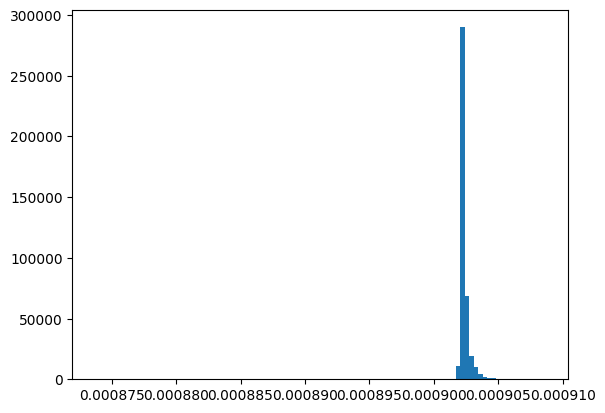

In [23]:
# Evaluate on a single sample (for now)
model.eval()
img_tens, gt = train_set[2]
img_tens = img_tens.unsqueeze(0)
test = model(img_tens)

In [24]:
test.squeeze(dim=0).shape

torch.Size([1, 640, 640])

In [25]:
test = test.squeeze(dim=0)

In [26]:
test.unique()

tensor([0.])

In [27]:
# plot image and prediction simultaneously
utils.plot_img_pred(img_tens.squeeze(0),test)